In [1]:
library(tidyverse)
library(magrittr) # better handling of pipes
library(purrr) # to work with lists and map functions
library(glue) # to paste strings
library(stringr) # to hand strings
library(rvest) # rvest makes scraping easier
library(polite) # polite is the "polite" version of rvest
library(xml2) # makes it easier to work with HTML and XML from R
library(ggplot2)
library(httr)
library(visdat)
library(skimr)
library(zoo)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse



Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
os_c_df <- read_csv("data/Overseas_Cargo_dataset.csv")

New names:
* `` -> ...1

Rows: 39592 Columns: 25

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (20): ResourceID, Subject, Title, Description, Notes, Caveats, Source, ...
dbl   (3): ...1, Value, Multiplier
dttm  (1): Modified
date  (1): Period


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [3]:
os_c_df %>% skim()

── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             39592     
Number of columns          25        
_______________________              
Column type frequency:               
  character                20        
  Date                     1         
  numeric                  3         
  POSIXct                  1         
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
   skim_variable n_missing complete_rate   min   max empty n_unique whitespace
 1 ResourceID            0             1     6     6     0        1          0
 2 Subject               0             1    25    25     0        1          0
 3 Title                 0             1    54    54     0        1          0
 4 Description           0             1    96    96     0        1          0
 5 Notes                 0

In [4]:
trade_df <- os_c_df %>%
    filter(
        Label2 == "Total All Cargo", 
        Status == "F"
    ) %>% 
    select(Period, Label1, Measure, Value) %>%
    mutate(Measure = ifelse(Measure != "Gross weight value", "NZD_Value_mil", "Gross_Weight_kt"), Value = Value / 1000) %>%
    spread(key=Measure, value=Value) %>%
    rename(Trade = Label1) %>%
    arrange(Period, Trade)
    

trade_df %>% head()

Period,Trade,Gross_Weight_kt,NZD_Value_mil
<date>,<chr>,<dbl>,<dbl>
1988-01-31,Exports,550.458,799.476
1988-01-31,Imports,794.129,892.909
1988-02-29,Exports,906.514,1140.441
1988-02-29,Imports,726.047,940.189
1988-03-31,Exports,971.862,1236.020
1988-03-31,Imports,516.128,883.951


In [5]:
ImpExp_Value_df <- trade_df %>% 
    select(Period, Trade, NZD_Value_mil) %>%
    spread(key=Trade, value=NZD_Value_mil) %>%
    arrange(Period)

ImpExp_Value_df %>% head()

Period,Exports,Imports
<date>,<dbl>,<dbl>
1988-01-31,799.476,892.909
1988-02-29,1140.441,940.189
1988-03-31,1236.020,883.951
1988-04-30,1022.018,867.439
1988-05-31,1228.317,873.175
1988-06-30,1149.823,892.652


Warning message:
“Removed 14 row(s) containing missing values (geom_path).”
Warning message:
“Removed 14 row(s) containing missing values (geom_path).”


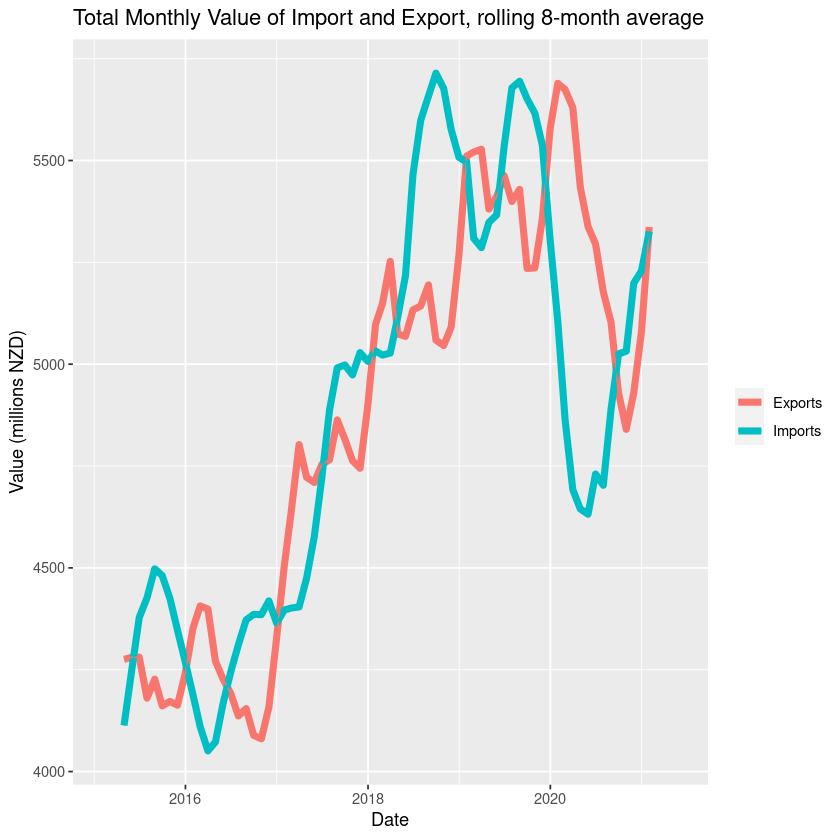

In [6]:
ImpExp_plot <- ImpExp_Value_df %>% filter(Period > "2015-01-01") %>%
    gather(key=trade, value=value, -Period) %>%
    group_by(trade) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA)) %>%
    ggplot(mapping = aes(x = Period, y = RA_Value, colour = trade)) + geom_line(lwd=2) +
    ggtitle("Total Monthly Value of Import and Export, rolling 8-month average") +
    ylab("Value (millions NZD)") + xlab("Date") + theme(legend.title = element_blank()) +
    geom_line()

ImpExp_plot

In [7]:
ImpExp_Weight_df <- trade_df %>% 
    select(Period, Trade, Gross_Weight_kt) %>%
    spread(key=Trade, value=Gross_Weight_kt) %>%
    arrange(Period)

ImpExp_Weight_df %>% head()

Period,Exports,Imports
<date>,<dbl>,<dbl>
1988-01-31,550.458,794.129
1988-02-29,906.514,726.047
1988-03-31,971.862,516.128
1988-04-30,961.191,640.725
1988-05-31,814.132,423.866
1988-06-30,1206.279,630.422


Warning message:
“Removed 14 row(s) containing missing values (geom_path).”
Warning message:
“Removed 14 row(s) containing missing values (geom_path).”


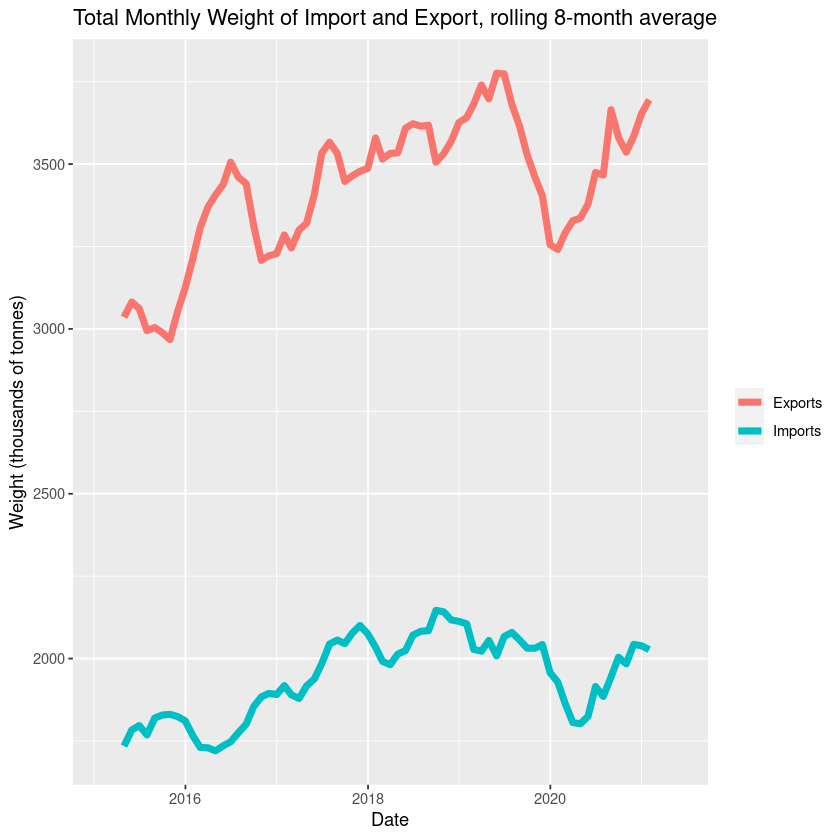

In [8]:
ImpExp_plot <- ImpExp_Weight_df %>% filter(Period > "2015-01-01") %>%
    gather(key=ImEx, value=value, -Period) %>%
    group_by(ImEx) %>%
    mutate(RA_Value = rollmean(value, k=8, fill=NA)) %>%
    ggplot(mapping = aes(x = Period, y = RA_Value, colour = ImEx)) + geom_line(lwd=2) +
    ggtitle("Total Monthly Weight of Import and Export, rolling 8-month average") +
    ylab("Weight (thousands of tonnes)") + xlab("Date") + 
    theme(legend.title = element_blank()) +
    geom_line()

ImpExp_plot